# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Thousands of cars are driven everyday and are essential to the daily lives and economic ecosystem of the world. It is important for car dealerships to understand the most important features that car buyers look at before buying a car. By doing so, the car dealerships will be able to prioritize acquiring and building cars with features that allow cars to be frequently sold for a high amount of money. Understanding this information will help dealerships increase profit and refocus their effort into a subset of cars. With a dataset of 426k cars and its specific details, we need to find evidence and patterns which show what features drive up the price at which cars are sold. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

To better understand the data at hand, it is important to understand what features are included and to remove unnecessary information that won't be useful. 

In [407]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV



In [408]:
data = pd.read_csv("data/vehicles.csv")
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [409]:
data.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [410]:
data.shape

(426880, 18)

Upon visualizing the first few rows and columns of the dataset, we can see there are a lot of cells without inputs, as well as many features related to the car. A few that might not be important to this analysis would be the ID and VIN number. These null values would also not be ideal for the analysis, so they will most likely be dropped. A deeper dive into the data could allow us to understand and decide what columns to keep and remove.

In [411]:
data.info

<bound method DataFrame.info of                 id                  region  price    year manufacturer  \
0       7222695916                prescott   6000     NaN          NaN   
1       7218891961            fayetteville  11900     NaN          NaN   
2       7221797935            florida keys  21000     NaN          NaN   
3       7222270760  worcester / central MA   1500     NaN          NaN   
4       7210384030              greensboro   4900     NaN          NaN   
...            ...                     ...    ...     ...          ...   
426875  7301591192                 wyoming  23590  2019.0       nissan   
426876  7301591187                 wyoming  30590  2020.0        volvo   
426877  7301591147                 wyoming  34990  2020.0     cadillac   
426878  7301591140                 wyoming  28990  2018.0        lexus   
426879  7301591129                 wyoming  30590  2019.0          bmw   

                           model condition    cylinders    fuel  odometer  \
0 

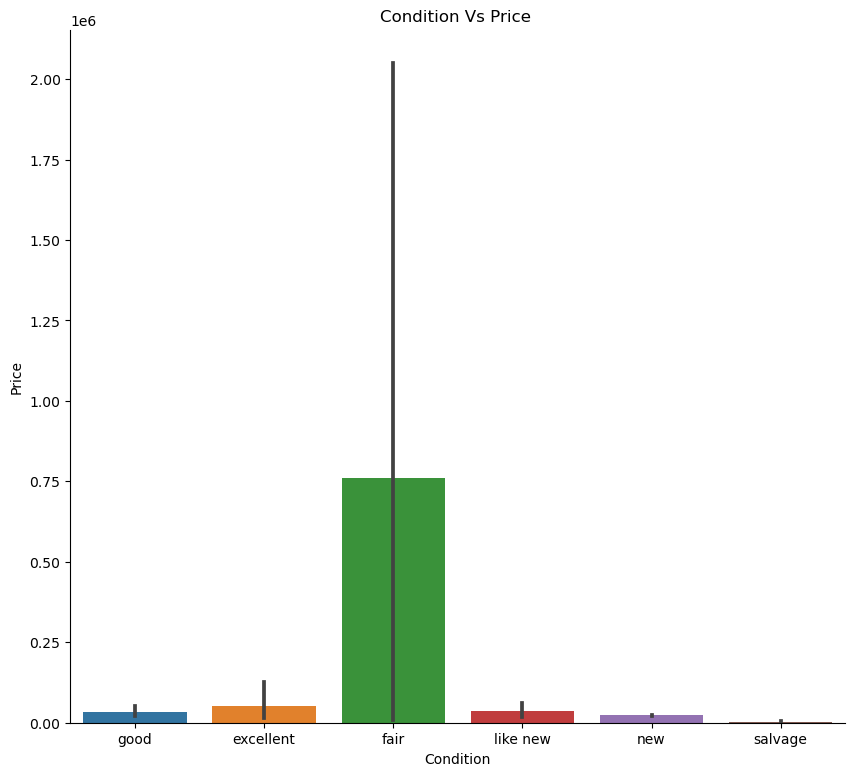

In [412]:
plt.figure(figsize=(10,9))
sns.barplot(x = data['condition'],y = data['price'])
plt.title('Condition Vs Price ')
plt.xlabel('Condition')
plt.ylabel('Price')
sns.despine()
plt.show()

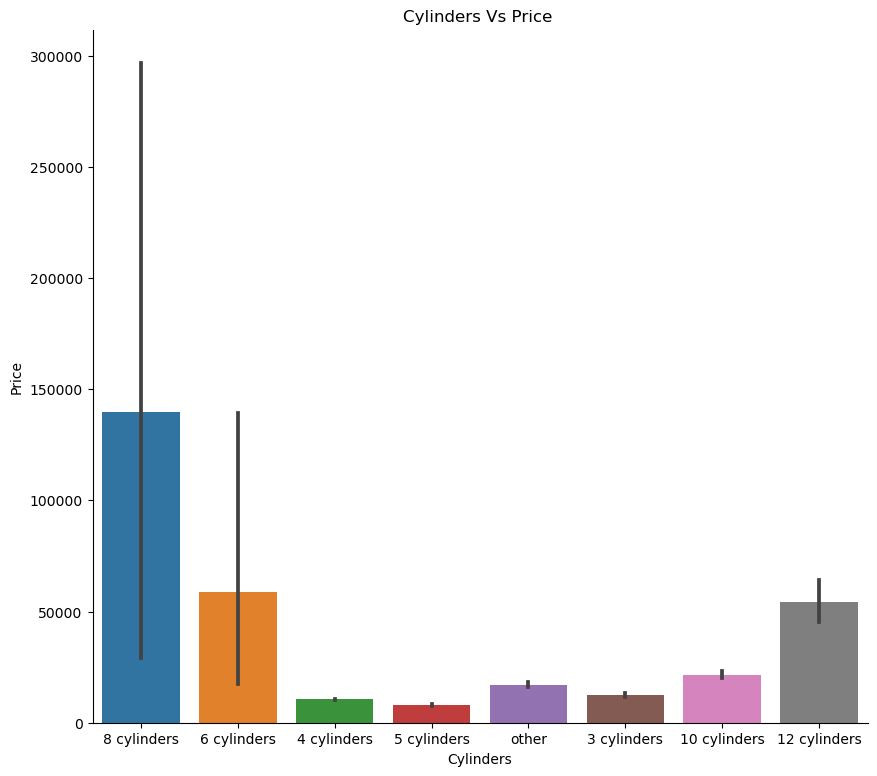

In [413]:
plt.figure(figsize=(10,9))
sns.barplot(x = data['cylinders'],y = data['price'])
plt.title('Cylinders Vs Price ')
plt.xlabel('Cylinders')
plt.ylabel('Price')
sns.despine()
plt.show()

In my opinion, cylinders and condition would have the most impact on the price at which a car is sold.Prior to any data cleanup, it seems like fair conditions and 8 cylinders sell for the highest cost. These bar plots also show that the price variability is extremely high. 

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [414]:
# ID and car VIN are metrics that dont have relation to whether or not a car is purchased
data = data.drop('id', axis = 1)
data = data.drop('VIN', axis = 1)

<Axes: >

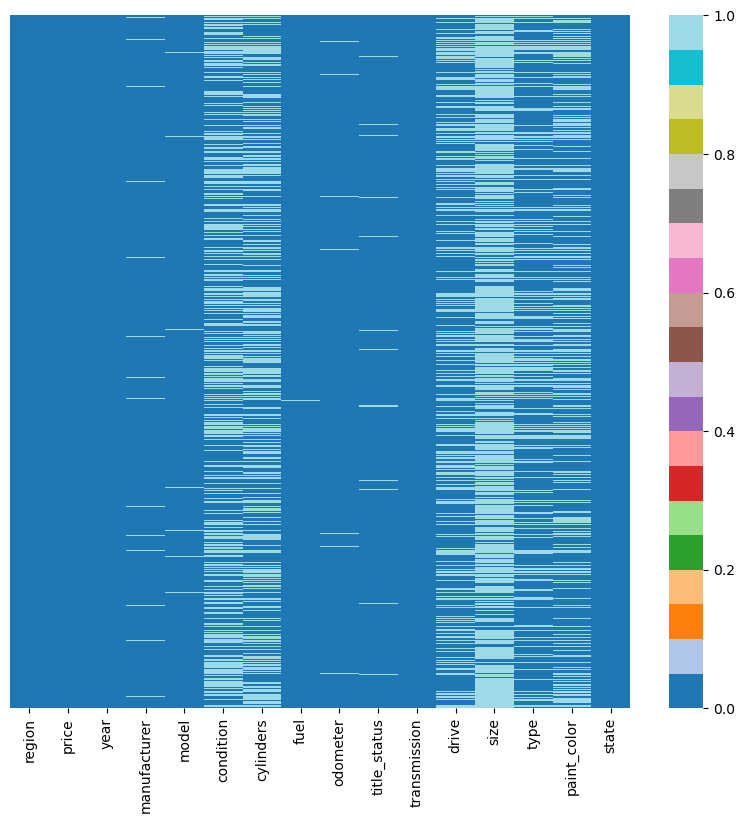

In [415]:
# this allows us to visualize the amount of null values in the database per column
plt.figure(figsize=(10,9))
sns.heatmap(data.isnull(), yticklabels=False, cbar=True, cmap='tab20')

In [416]:
# based on the null analysis above, we can see that a majority of the size column has null values. this should be dropped 
# as its data would not be relevant to the analysis
data = data.drop('size',axis = 1)

In [417]:
# dropping the null values from our dataset
data = data.dropna()
data.dtypes

region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
type             object
paint_color      object
state            object
dtype: object

In [418]:
data.var()

C:\Users\lcs_n\AppData\Local\Temp\ipykernel_15536\445316826.py:1: FutureWarning:

The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



price       1.314616e+14
year        9.208259e+01
odometer    4.832893e+10
dtype: float64

In [419]:

price_low = data["price"].quantile(0.20)
price_hi  = data["price"].quantile(0.80)
# year_low = data["year"].quantile(0.15)
# year_hi  = data["year"].quantile(0.85)
# odo_low = data["odometer"].quantile(0.15)
# odo_hi  = data["odometer"].quantile(0.85)

data = data[(data["price"] < price_hi) & (data["price"] > price_low)]
data_ori = data
data['price'] = np.log(data['price'])
# data = data[(data["year"] < year_hi) & (data["year"] > year_low)]
# data = data[(data["odometer"] < odo_hi) & (data["odometer"] > odo_low)]

C:\Users\lcs_n\AppData\Local\Temp\ipykernel_15536\1385300240.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




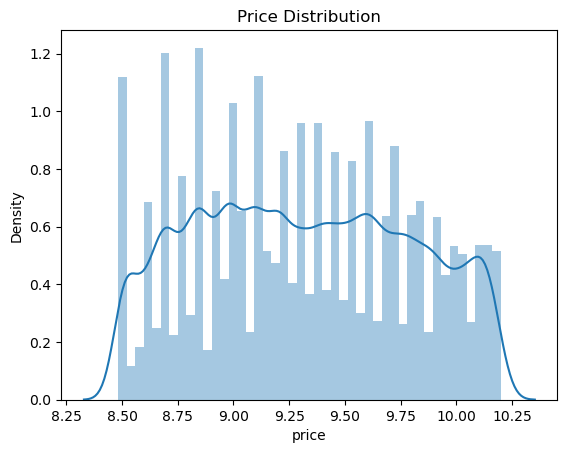

In [420]:
sns.distplot(data['price'])
plt.title("Price Distribution")
plt.show()

In [421]:
# separating the categorical and numerical values of the dataset
data_cat = data.select_dtypes(include=[object])
data_num = data.select_dtypes(include = [int,float])
data_num

,price,year,odometer
31,9.615805,2013.0,128000.0
55,9.898475,2004.0,88000.0
59,9.546813,2012.0,95000.0
65,10.021271,2001.0,144700.0
73,9.615805,2017.0,90000.0
...,...,...,...
426793,9.680281,2018.0,36465.0
426808,9.798127,2005.0,130000.0
426809,9.798127,1990.0,114400.0
426831,9.190138,1985.0,115000.0


In [422]:
# Using labelEncoder to transform all the categorical values to numerical
labelE = LabelEncoder()
data_cat = list(data_cat)
data[data_cat] = data[data_cat].apply(labelE.fit_transform)

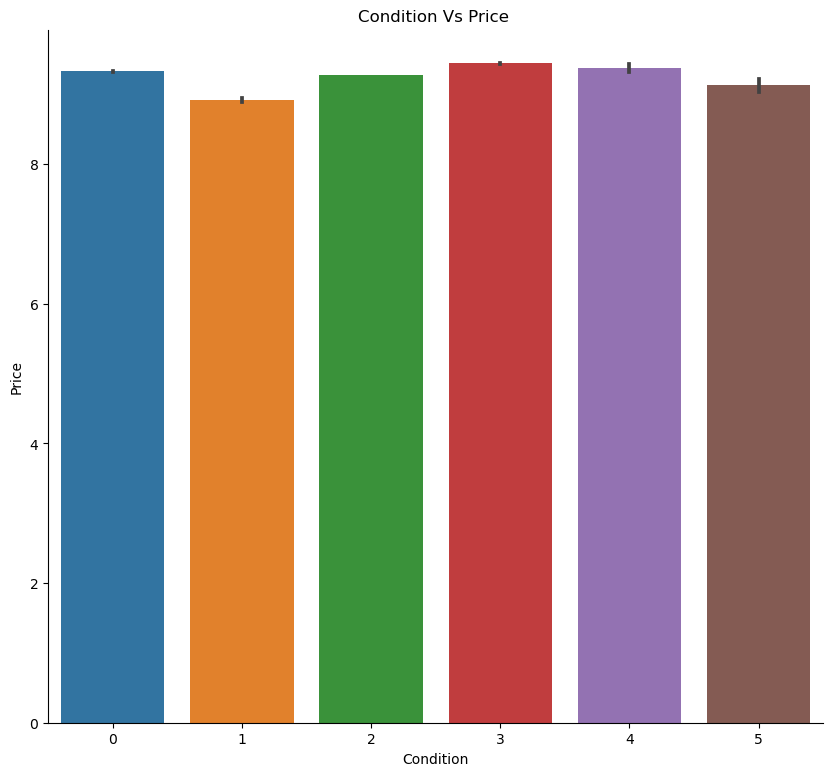

In [423]:
plt.figure(figsize=(10,9))
sns.barplot(x = data['condition'],y = data['price'])
plt.title('Condition Vs Price ')
plt.xlabel('Condition')
plt.ylabel('Price')
sns.despine()
plt.show()

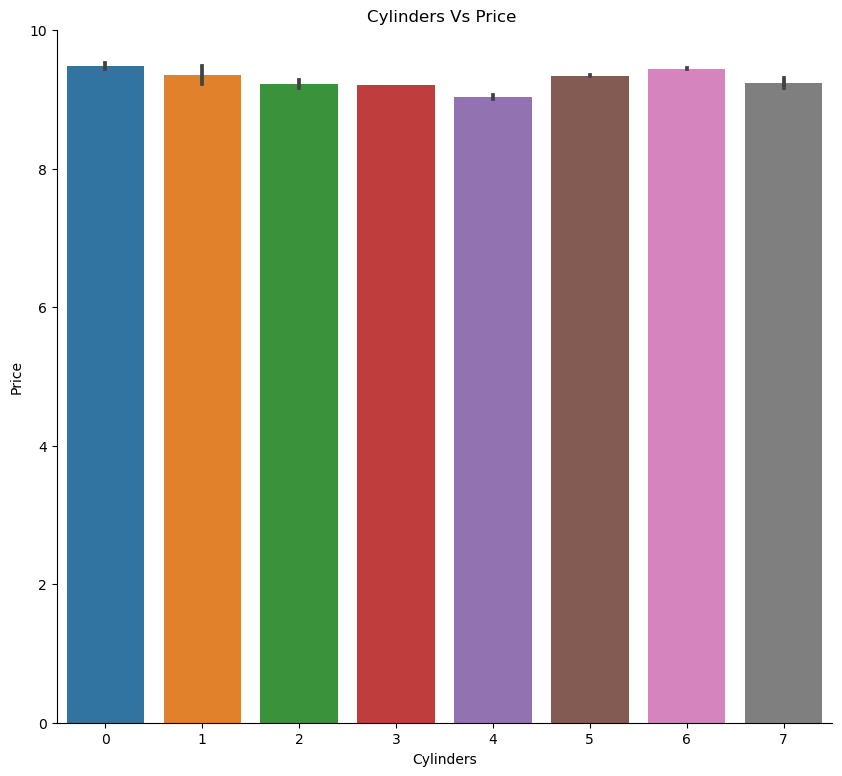

In [424]:
plt.figure(figsize=(10,9))
sns.barplot(x = data['cylinders'],y = data['price'])
plt.title('Cylinders Vs Price ')
plt.xlabel('Cylinders')
plt.ylabel('Price')
sns.despine()
plt.show()

After cleaning up the data, 6 cylinders sell for the most whereas the distribution of the conditions of cars evened out (with fair still being the highest value sold)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [425]:
X = data.drop(["price"], axis = 1)
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Sequential Feature Selection

In [426]:
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                          ('scale', StandardScaler()),
                         ('model', LinearRegression())])

In [427]:
param_dict1 = {'selector__n_features_to_select': [2, 3, 4, 5, 6]}
selector_finder = GridSearchCV(estimator = selector_pipe, 
                             param_grid=param_dict1,
                            scoring = "neg_mean_squared_error")

In [428]:
selector_finder.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SequentialFeatureSelector(estimator=LinearRegression())),
                                       ('scale', StandardScaler()),
                                       ('model', LinearRegression())]),
             param_grid={'selector__n_features_to_select': [2, 3, 4, 5, 6]},
             scoring='neg_mean_squared_error')

In [429]:
best_selector = selector_finder.best_estimator_
selector_train_mse = mean_squared_error(y_train, best_selector.predict(X_train))
selector_test_mse = mean_squared_error(y_test, best_selector.predict(X_test))
print(selector_train_mse)
print(selector_test_mse)

0.18796538261011578
0.18581994105427505


# Ridge

In [430]:
sequential_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                            ('scale', StandardScaler()),
                            ('reg', Ridge())])

In [431]:
parameters_to_try = {'reg__alpha': 10**np.linspace(-5,4,10)}

In [432]:
model_finder = GridSearchCV(estimator = sequential_pipe,
                                param_grid = parameters_to_try,
                           scoring = "neg_mean_squared_error")

In [433]:
model_finder.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('poly_features',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('scale', StandardScaler()),
                                       ('reg', Ridge())]),
             param_grid={'reg__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])},
             scoring='neg_mean_squared_error')

In [434]:
best_model = model_finder.best_estimator_
ridge_train_mse = mean_squared_error(y_train, best_model.predict(X_train))
ridge_test_mse = mean_squared_error(y_test, best_model.predict(X_test))
best_model

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scale', StandardScaler()), ('reg', Ridge(alpha=10000.0))])

In [435]:
print(ridge_train_mse)
print(ridge_test_mse)

0.13829010343052356
0.13964615413411752


In [436]:
best_coef = best_model['reg'].coef_[:14]

In [437]:
model_finder.cv_results_

{'mean_fit_time': array([1.00431318, 1.0283349 , 0.94365792, 0.92103705, 0.99130135,
        1.07760215, 1.03514104, 0.90682478, 0.896415  , 0.91062756]),
 'std_fit_time': array([0.06163729, 0.07648027, 0.04250011, 0.02383266, 0.07210586,
        0.10674292, 0.10878266, 0.07232373, 0.03197036, 0.06515744]),
 'mean_score_time': array([0.11170149, 0.10409484, 0.09468632, 0.08948154, 0.10889878,
        0.11350336, 0.12010942, 0.09348478, 0.10789833, 0.09989123]),
 'std_score_time': array([0.01230081, 0.01600213, 0.00961257, 0.01117417, 0.01594455,
        0.00578804, 0.01668842, 0.00862431, 0.01058087, 0.01054323]),
 'param_reg__alpha': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                    1000.0, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg__alpha': 1e-05},
  {'reg__alpha': 0.0001},
  {'reg__alpha': 0.001},


# Sequential with Linear Regresison

In [438]:
data.shape

(69569, 15)

In [439]:
seqReg_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                           ('selector', SequentialFeatureSelector(LinearRegression(), 
                                                                  n_features_to_select=6)),
                           ('linreg', LinearRegression())])

In [440]:
seqReg_pipe.fit(X_train, y_train)



Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=6)),
                ('linreg', LinearRegression())])

In [441]:
seqReg_train_mse = mean_squared_error(y_train, seqReg_pipe.predict(X_train))
seqReg_test_mse = mean_squared_error(y_test, seqReg_pipe.predict(X_test))
print(seqReg_train_mse)
print(sequential_test_mse)

0.13045729102009967
0.18552860682699043


In [442]:
seqReg_pipe['linreg'].coef_

array([ 2.39738459e+02, -1.21671882e-01, -2.60980282e-02,  2.05807532e-05,
        3.42227987e-03,  1.81400342e-02])

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Although the SequentialFeatureSelection with Linear Regression resulted with the lowest MSE for both test and training datas, the results did not make sense. SFS is a brute force algorithim which resulted with region haveing an extreme importance compared to every other feature. The next best model was the one depicted below using Ridge and SFS with an alpha of 10000. The model had a MSE of 0.13. This result shows that year, title and manufacturer have the most importance to the price of used cars. The odometer number, drive and fuel consumption had the least correlation to the price of used cars. 

In [443]:
print(ridge_train_mse)
print(ridge_test_mse)

0.13829010343052356
0.13964615413411752


<Axes: >

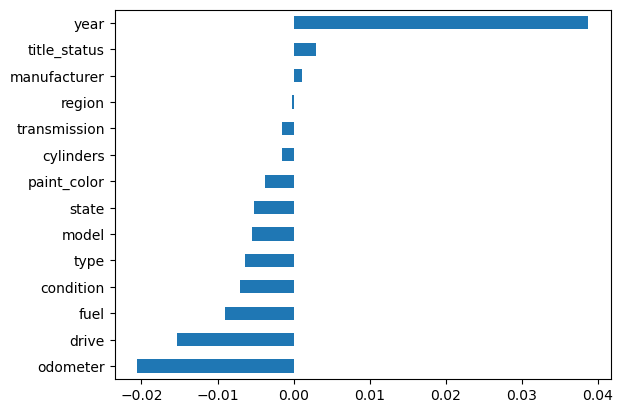

In [444]:
chart = pd.Series(best_coef, X_train.columns)
chart.sort_values().plot(kind = 'barh')

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

The data we intially received included an assortment of features about cars that were sold at dealerships. Our job was to find any trends that could potentially influence the price of a used car. Throughout our analysis, we cleaned, manipulated, and scaled our data so that it would properly fit in a model and accurately locate these trends. We utilized a Ridge model, with an alpha level of 10000 and polynomial feature of 3. The results of our model yielded a 0.13 MSE for both training and testing data and found correlations between car features and its price. Depicted below is the correlation levels to all the features we deemed important enough the keep in the dataset. Features such as Id, VIM, and Size were neglected. ID and VIM do not relate to a car's price whereas almost 75% of the data for size was missing.

<Axes: >

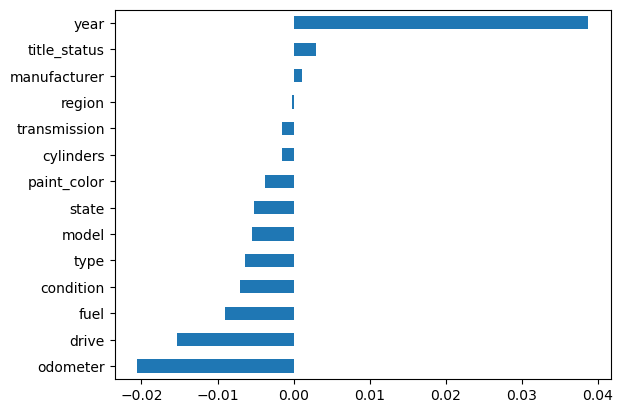

In [445]:
chart.sort_values().plot(kind = 'barh')

In [446]:
chart.sort_values(ascending = False)

year            0.038700
title_status    0.002903
manufacturer    0.001054
region         -0.000160
transmission   -0.001514
cylinders      -0.001533
paint_color    -0.003717
state          -0.005252
model          -0.005505
type           -0.006360
condition      -0.007059
fuel           -0.009071
drive          -0.015280
odometer       -0.020565
dtype: float64

Based on the chart and table above, it can be seen that the year of the car, title_status and manufacturer have the highest impact on the price of used cars, with year being almost 15x as influential as the other two. It is recommended that your car dealership should look out for cars which have been recently made or of an extremely older model. Newer models have more features and have more up to date features which would drive their prices up. Older models are no longer manufactured which makes its price go up since people might want to collect them. Because these features have a higher impact on the price of the vehicle, car dealers should revise their purchasing/selling business plan to revolve around these feature for better profits.